In [91]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
client_dir = "../data/json/clients/"
client_dict = {}
for f in os.listdir(client_dir):
    with open(os.path.join(client_dir, f), "r") as fp:
        client = json.load(fp)
        client_dict[client["handle"]] = client
print("Number of clients: {}".format(len(client_dict)))

Number of clients: 213


In [3]:
hacker_dir = "../data/json/hackers/"
hacker_dict = {}
for f in os.listdir(hacker_dir):
    with open(os.path.join(hacker_dir, f), "r") as fp:
        hacker = json.load(fp)
        if "username" in hacker: # some empty files
            hacker_dict[hacker["username"]] = hacker
print("Number of hackers: {}".format(len(hacker_dict)))

Number of hackers: 1897


In [4]:
report_dir = "../data/json/reports"
report_list = []
for f in os.listdir(report_dir):
    with open(os.path.join(report_dir, f), "r") as fp:
        report_list.append(json.load(fp))
print("Number of reports: {}".format(len(report_list)))

Number of reports: 6028


In [74]:
data = []

for report in report_list:
    # Only keeps labeled reports w/ bouties
    if ((not report["has_bounty?"]) 
        or report["substate"] == "duplicate"
        or "bounty_amount" not in report): continue
    datapoint = []
    
    # y
    datapoint.append(float(report["bounty_amount"]))
    
    # 0: severity indicator
    severity_indicator = int("severity" in report)
    datapoint.append(severity_indicator)
    
    # 1-4: one-hot encoding for 4 rating
    for rating in ["low", "medium", "high", "critical"]:  
        datapoint.append(int(severity_indicator == 1 and report["severity"]["rating"] == rating))
        
    # 5: severity score indicator
    score_indicator = int(severity_indicator == 1 and "score" in report["severity"]) 
    datapoint.append(score_indicator)                     
    
    # 6: severity score
    datapoint.append(report["severity"]["score"] if score_indicator else 0.0)
    
    # 7: metric indicator
    metric_indicator = int(severity_indicator == 1 and "metrics" in report["severity"])
    datapoint.append(metric_indicator)
    
    # 8-10: one-hot encoding for 3 confidentiality
    for conf in ["none", "low", "high"]:
        datapoint.append(int(metric_indicator == 1 and report["severity"]["metrics"]["confidentiality"] == conf))
    
    # 11-13: one-hot encoding for 3 privileges_required
    for prev in ["none", "low", "high"]:
        datapoint.append(int(metric_indicator == 1 and report["severity"]["metrics"]["privileges_required"] == prev))
    
    # 14-15: one-hot encoding for 2 user_interaction
    for ui in ["none", "required"]:
        datapoint.append(int(metric_indicator == 1 and report["severity"]["metrics"]["user_interaction"] == ui)) 
    
    # 16-19: one-hot encoding for 4 attack_vector
    for attv in ["local", "adjacent", "physical", "network"]:
        datapoint.append(int(metric_indicator == 1 and report["severity"]["metrics"]["attack_vector"] == attv))
    
    # 20-21: one-hot encoding for 2 attack_complexity
    for attc in ["low", "high"]:
        datapoint.append(int(metric_indicator == 1 and report["severity"]["metrics"]["attack_complexity"] == attc))
    
    # 22-24: one-hot encoding for 3 integrity
    for inte in ["none", "low", "high"]:
        datapoint.append(int(metric_indicator == 1 and report["severity"]["metrics"]["integrity"] == inte))
    
    # 25-27: one-hot encoding for 3 availability
    for avai in ["none", "low", "high"]:
        datapoint.append(int(metric_indicator == 1 and report["severity"]["metrics"]["availability"] == avai))

    # 28: number of activities
    datapoint.append(len(report["activities"]))
    
    # 29: is_external_bug
    datapoint.append(int(report["is_external_bug"]))
    
    if report["reporter"]["username"] not in hacker_dict: continue
    hacker = hacker_dict[report["reporter"]["username"]]
    
    # 30: hackerone_triager
    datapoint.append(int(hacker["hackerone_triager"]))
    
    # 31: hacker target count
    datapoint.append(hacker["target_count"])
    
    # 32-33: hacker impact 
    impact_indicator = int(hacker["impact"] is not None)
    datapoint.append(impact_indicator)
    datapoint.append(float(hacker["impact"]) if impact_indicator else 0.0)
    
    
    # 34-35: hacker impact percentile
    impact_perc_indicator = int(hacker["impact_percentile"] is not None)
    datapoint.append(impact_perc_indicator)
    datapoint.append(float(hacker["impact_percentile"]) if impact_perc_indicator else 0.0)
    
    # 36: hacker report count
    datapoint.append(hacker["report_count"])
    
    # 37-38: hacker signal
    signal_indicator = int(hacker["signal"] is not None)
    datapoint.append(signal_indicator)
    datapoint.append(float(hacker["signal"]) if signal_indicator else 0.0)
    
    # 39-40: hacker signal percentile
    signal_perc_indicator = int(hacker["signal_percentile"] is not None)
    datapoint.append(signal_perc_indicator)
    datapoint.append(float(hacker["signal_percentile"]) if signal_perc_indicator else 0.0)
    
    # 41-42: hacker reputaion
    reputation_indicator = int(hacker["reputation"] is not None)
    datapoint.append(reputation_indicator)
    datapoint.append(int(hacker["reputation"]) if reputation_indicator else 0.0)
    
    # 43-44: hacker rank
    rank_indicator = int(hacker["rank"] is not None)
    datapoint.append(rank_indicator)
    datapoint.append(int(hacker["rank"]) if rank_indicator else 0)
    
    client = client_dict[report["team"]["handle"]]
    
    # 45-46: client total bounties paid
    total_bounties_paid_indicator = int(client["total_bounties_paid"] is not None)
    datapoint.append(total_bounties_paid_indicator)
    datapoint.append(float(client["total_bounties_paid"]) if total_bounties_paid_indicator else 0.0)
    
    # 47-48: client bug count
    bug_count_indicator = int("bug_count" in client)
    datapoint.append(bug_count_indicator)
    datapoint.append(int(client["bug_count"]) if bug_count_indicator else 0)
    
    # 49: client researcher count
    datapoint.append(int(client["researcher_count"]))
    
    # 50-51: client target signal
    target_signal_indicator = int(client["target_signal"] is not None)
    datapoint.append(target_signal_indicator)
    datapoint.append(float(client["target_signal"]) if target_signal_indicator else 0.0)
    
    # 52-53: client avg upper
    average_bounty_upper_range_indicator = int(client["average_bounty_upper_range"] is not None)
    datapoint.append(average_bounty_upper_range_indicator)
    datapoint.append(float(client["average_bounty_upper_range"]) if average_bounty_upper_range_indicator else 0.0)
  
    # 54-55: client avg lower
    average_bounty_lower_range_indicator = int(client["average_bounty_lower_range"] is not None)
    datapoint.append(average_bounty_lower_range_indicator)
    datapoint.append(float(client["average_bounty_lower_range"]) if average_bounty_lower_range_indicator else 0.0)

    # 56-57: client top upper
    top_bounty_upper_range_indicator = int(client["top_bounty_upper_range"] is not None)
    datapoint.append(top_bounty_upper_range_indicator)
    datapoint.append(float(client["top_bounty_upper_range"]) if top_bounty_upper_range_indicator else 0.0)

    # 58-59: client top lower
    top_bounty_lower_range_indicator = int(client["top_bounty_lower_range"] is not None)
    datapoint.append(top_bounty_lower_range_indicator)
    datapoint.append(float(client["top_bounty_lower_range"]) if top_bounty_lower_range_indicator else 0.0)
    
    data.append(datapoint)

In [85]:
data_np = np.asarray(data)
X, y = data_np[:, 1:], data_np[:, 0]
print("X shape: {}, y shape: {}".format(X.shape, y.shape))

X shape: (2865, 60), y shape: (2865,)


In [88]:
dev_ratio = 0.1
dev_size = int(dev_ratio * data_np.shape[0])
np.random.shuffle(data_np)
train_data = data_np[:-dev_size, :]
dev_data = data_np[-dev_size:, :]
print("Train data: {}, Dev data: {}".format(train_data.shape, dev_data.shape))
np.save("../data/npy/train", train_data)
np.save("../data/npy/dev", dev_data)

Train data: (2579, 61), Dev data: (286, 61)


1.0 25000.0 970.6868237347295 2198.0856190907366


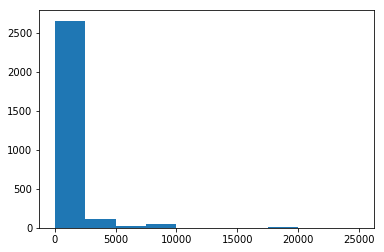

In [93]:
plt.hist(y)
print(y.min(), y.max(), y.mean(), y.std())